In [814]:
from glob import iglob
import nltk
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from datetime import timedelta, date, datetime
import bs4
import requests
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
import re
import logging
import sklearn
import numpy as np

# Load BBC RSS feed data from url

### Create DataFrame of rss feed content - 95 articles 

In [519]:
def get_rss_feed(url):
    """
       Return a Pandas dataframe containing the RSS feed contents.
       Source: https://practicaldatascience.co.uk/data-science/how-to-read-an-rss-feed-in-python
       Modified to use BeautifulSoup (b4)
       
    Args: 
        url (string): URL of the RSS feed to read.

    Returns:
        df (dataframe): Pandas dataframe containing the RSS feed contents.
    """
    
    response = get_html_source(url)
    
    df = pd.DataFrame(columns = ['title', 'pubDate', 'guid', 'link', 'description'])

    with response as r:   
        # we use BeautifulSoup with `lxml-xml` type to parse the rss feed
        soup = BeautifulSoup(r.text , 'lxml-xml')
        items = soup.find_all('item')

        for item in items:   
            try:
                title = item.find('title').text
                pubDate = item.find('pubDate').text
                guid = item.find('guid').text
                link = item.find('link').text
                description = item.find('description').text

                row = {'title': title, 'pubDate': pubDate, 'guid': guid, 'link': link, 'description': description}
                df = df.append(row, ignore_index=True)
            except Exception as ex:
                print(ex)
                continue
    return df

In [520]:
url = "http://feeds.bbci.co.uk/news/politics/rss.xml"
data_df = get_rss_feed(url)
data_df

,title,pubDate,guid,link,description
0,Nicola Sturgeon says gender reform row will go...,"Tue, 17 Jan 2023 14:29:34 GMT",https://www.bbc.co.uk/news/uk-scotland-scotlan...,https://www.bbc.co.uk/news/uk-scotland-scotlan...,Scotland's first minister says the courts will...
1,Tech bosses could face jail after Tory MPs rev...,"Tue, 17 Jan 2023 14:00:26 GMT",https://www.bbc.co.uk/news/uk-politics-64298338,https://www.bbc.co.uk/news/uk-politics-6429833...,The government has conceded after nearly 50 Co...
2,Scotland gender bill: What next for Sunak and ...,"Tue, 17 Jan 2023 08:26:47 GMT",https://www.bbc.co.uk/news/uk-politics-64300263,https://www.bbc.co.uk/news/uk-politics-6430026...,"The Union has a clash on its hands, writes Jam..."
3,Covid-19 support worth £4.5bn lost to error an...,"Tue, 17 Jan 2023 13:23:09 GMT",https://www.bbc.co.uk/news/uk-politics-64304428,https://www.bbc.co.uk/news/uk-politics-6430442...,The tax authority reveals an estimated £4.5bn ...
4,"Pay rises at fastest pace for over 20 years, b...","Tue, 17 Jan 2023 12:01:42 GMT",https://www.bbc.co.uk/news/business-64290162,https://www.bbc.co.uk/news/business-64290162?a...,Wages rose at their fastest rate since 2001 ex...
...,...,...,...,...,...
89,House of Lords: What is it and what could Labo...,"Wed, 07 Dec 2022 12:54:46 GMT",https://www.bbc.co.uk/news/uk-politics-63864428,https://www.bbc.co.uk/news/uk-politics-6386442...,"The House of Lords is ""undemocratic"" and ""inde..."
90,Eleven gambles that went wrong for Liz Truss,"Sun, 04 Dec 2022 00:09:13 GMT",https://www.bbc.co.uk/news/uk-63838387,https://www.bbc.co.uk/news/uk-63838387?at_medi...,Nick Robinson looks at the biggest risks taken...
91,The local battles behind Tory housing divisions,"Tue, 06 Dec 2022 13:51:04 GMT",https://www.bbc.co.uk/news/uk-politics-63819647,https://www.bbc.co.uk/news/uk-politics-6381964...,Local housing targets are being watered down i...
92,Can Labour revive its fortunes in Scotland?,"Mon, 05 Dec 2022 17:57:33 GMT",https://www.bbc.co.uk/news/uk-scotland-scotlan...,https://www.bbc.co.uk/news/uk-scotland-scotlan...,The party hopes its proposed constitutional re...


# Create the Corpus

### Extract the text of each article to create a corpus

In [552]:
rss_feed = requests.get("http://feeds.bbci.co.uk/news/politics/rss.xml")
soup = BeautifulSoup(rss_feed.content, 'xml')

# Find all the links in the RSS feed
links = soup.find_all('link')

corpus = []
# Iterate over the links
for link in links:
    article_corpus = []
    # Get the content of each article
    article = requests.get(link.text)
    article_soup = BeautifulSoup(article.content, 'html.parser')
    # Extract the text of the article by finding the tag containing the article text
    article_texts = article_soup.find_all('div', {'data-component': 'text-block', 'class': 'ssrcss-11r1m41-RichTextComponentWrapper ep2nwvo0'})
    for text in article_texts:
        article_text = text.find('div', {'class': 'ssrcss-7uxr49-RichTextContainer e5tfeyi1'}).find('p', {'class': 'ssrcss-1q0x1qg-Paragraph eq5iqo00'})
        if article_text:
            article_corpus.append(article_text.get_text())
    corpus.append(' '.join(article_corpus))

In [553]:
del corpus[0:2]

In [648]:
# Check 95 articles present in list
len(corpus)

94

# Tokenize: Preprocess the text data

#### Create tokens from the list of articles

In [557]:
import nltk
nltk.download("punkt")

# create an empty list to store the tokenized articles
tokenized_corpus = []

# iterate over the articles
for article in corpus:
    # tokenize the text
    tokens = nltk.word_tokenize(article)
    # append the tokens to the list
    tokenized_corpus.append(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kerennytorres/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Remove stopwords from the list of tokens
* lower case all words before removing
* remove alphanumeric elements present in the list
* filter tokenized words that are not included in stopwords

In [599]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    return [word.lower() for word in text if word.lower() not in stopwords]

filtered_corpus = [remove_stopwords(doc) for doc in tokenized_corpus]

# Remove symbols that are not alphanumeric in the list of tokens
corpus_clean = [[token for token in article if token.isalnum()] for article in filtered_corpus]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kerennytorres/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [647]:
# Remove unwanted words not in stopwords
unwanted_words = ['the','bbc','uk','would','said','mr','ms','i','but','government','labour','people']

def filter_words(text, unwanted_words):
    return filter(lambda x: x not in unwanted_words, text)

filtered_corpus = [list(filter_words(doc, unwanted_words)) for doc in corpus_clean]

# Vectorize using TF-IDF
Not needed if using LdaMulticore

In [649]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer()
#vectors = vectorizer.fit_transform(filtered_corpus)
#pd.DataFrame(vectors.todense(), columns = vectorizer.get_feature_names())

# Topic Modelling

In [621]:
dct = gensim.corpora.Dictionary(filtered_corpus)
corpus1 = [dct.doc2bow(line) for line in filtered_corpus]

In [664]:
lda_model = LdaMulticore(corpus=corpus1,
                         id2word=dct,
                         random_state=100,
                         num_topics=10,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

In [665]:
lda_model.save('lda_model.model')

In [656]:
ldamodel = lda_model.print_topics()
ldamodel

[(0,
  '0.004*"climate" + 0.003*"emissions" + 0.003*"corbyn" + 0.003*"zero" + 0.003*"net" + 0.003*"party" + 0.003*"supporters" + 0.002*"steel" + 0.002*"report" + 0.002*"coal"'),
 (1,
  '0.006*"minister" + 0.005*"party" + 0.005*"one" + 0.005*"also" + 0.004*"scottish" + 0.004*"could" + 0.004*"pay" + 0.004*"prime" + 0.004*"sunak" + 0.004*"says"'),
 (2,
  '0.005*"work" + 0.004*"says" + 0.004*"ireland" + 0.004*"northern" + 0.004*"gambling" + 0.003*"strike" + 0.003*"eu" + 0.003*"new" + 0.003*"also" + 0.003*"system"'),
 (3,
  '0.002*"donelan" + 0.002*"greece" + 0.002*"museum" + 0.001*"sculptures" + 0.001*"british" + 0.001*"inflation" + 0.001*"osborne" + 0.001*"greek" + 0.001*"channel" + 0.001*"rate"'),
 (4,
  '0.003*"israeli" + 0.002*"site" + 0.002*"compound" + 0.002*"ahmad" + 0.001*"lord" + 0.001*"jerusalem" + 0.001*"israel" + 0.001*"officials" + 0.001*"minister" + 0.001*"police"'),
 (5,
  '0.002*"court" + 0.002*"rwanda" + 0.002*"appeal" + 0.002*"scheme" + 0.001*"migrants" + 0.001*"home" + 0

In [659]:
#topic_word_probs = ldamodel.get_topic_word_probs() 
#doc_topic_probs = ldamodel.get_document_topic_probs()

In [ ]:
#corpus_lda = Sparse2Corpus(vectors, documents_columns=False)
#lda_model = gensim.models.LdaModel(corpus_lda, num_topics=10)
#topics = lda_model.show_topics(num_topics=10, num_words=5)
#topics

In [625]:
topics = lda_model.show_topics(num_topics=10, num_words=5)
topics

[(0,
  '0.004*"climate" + 0.003*"emissions" + 0.003*"corbyn" + 0.003*"zero" + 0.003*"net"'),
 (1,
  '0.006*"minister" + 0.005*"party" + 0.005*"one" + 0.005*"also" + 0.004*"scottish"'),
 (2,
  '0.005*"work" + 0.004*"says" + 0.004*"ireland" + 0.004*"northern" + 0.004*"gambling"'),
 (3,
  '0.002*"donelan" + 0.002*"greece" + 0.002*"museum" + 0.001*"sculptures" + 0.001*"british"'),
 (4,
  '0.003*"israeli" + 0.002*"site" + 0.002*"compound" + 0.002*"ahmad" + 0.001*"lord"'),
 (5,
  '0.002*"court" + 0.002*"rwanda" + 0.002*"appeal" + 0.002*"scheme" + 0.001*"migrants"'),
 (6,
  '0.005*"rwanda" + 0.003*"asylum" + 0.001*"mohammed" + 0.001*"kigali" + 0.001*"seekers"'),
 (7,
  '0.008*"protocol" + 0.006*"ireland" + 0.006*"northern" + 0.005*"eu" + 0.003*"agreement"'),
 (8,
  '0.003*"cats" + 0.003*"spiking" + 0.003*"also" + 0.002*"police" + 0.002*"ukraine"'),
 (9,
  '0.008*"nhs" + 0.005*"ambulance" + 0.005*"strike" + 0.004*"health" + 0.003*"action"')]

In [639]:
topic_list = [(topic[0], [word.split('*')[1] for word in topic[1].split(' + ')]) for topic in topics]
topic_list

[(0, ['"climate"', '"emissions"', '"corbyn"', '"zero"', '"net"']),
 (1, ['"minister"', '"party"', '"one"', '"also"', '"scottish"']),
 (2, ['"work"', '"says"', '"ireland"', '"northern"', '"gambling"']),
 (3, ['"donelan"', '"greece"', '"museum"', '"sculptures"', '"british"']),
 (4, ['"israeli"', '"site"', '"compound"', '"ahmad"', '"lord"']),
 (5, ['"court"', '"rwanda"', '"appeal"', '"scheme"', '"migrants"']),
 (6, ['"rwanda"', '"asylum"', '"mohammed"', '"kigali"', '"seekers"']),
 (7, ['"protocol"', '"ireland"', '"northern"', '"eu"', '"agreement"']),
 (8, ['"cats"', '"spiking"', '"also"', '"police"', '"ukraine"']),
 (9, ['"nhs"', '"ambulance"', '"strike"', '"health"', '"action"'])]

In [650]:
# Create a list removing tuples 
all_words = [str(word) for topic in topic_list for word in topic]
# Create a string of all the words in your list
text = " ".join(all_words)

# Create a Word Cloud

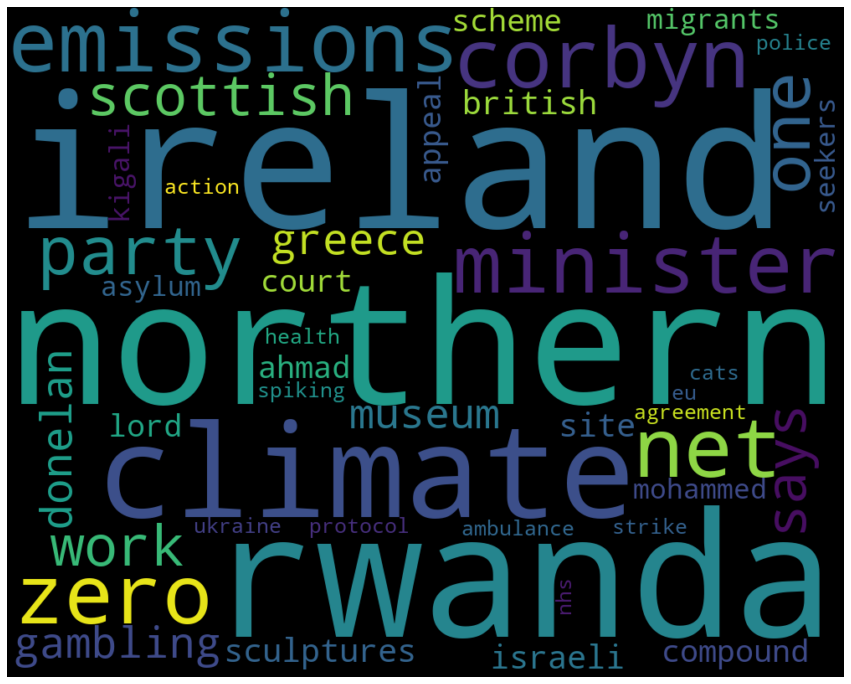

In [773]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a word cloud object
wordcloud = WordCloud(width=1000, height=800).generate(text)

# Display the word cloud
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("Week-1-17.png")
plt.show()

# Create a Network of Words

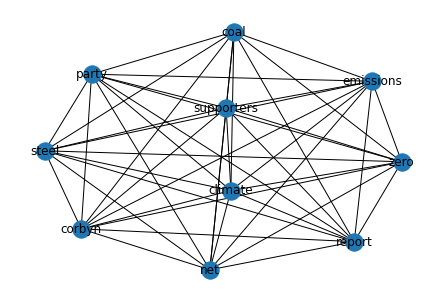

In [841]:
import networkx as nx
# Create an empty graph
G = nx.Graph()
topics = lda_model.show_topics(num_topics=1, num_words=10, formatted=False)

# Add nodes to the graph # Add edges to the graph
for topic in topics:
    for i in range(len(topic[1])):
        word = topic[1][i][0]
        G.add_node(word)
        for j in range(i+1, len(topic[1])):
            word2 = topic[1][j][0]
            G.add_edge(word, word2)

# Draw the graph
pos = nx.fruchterman_reingold_layout(G)
nx.draw(G, pos, with_labels=True,)

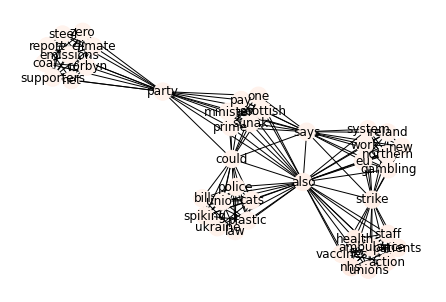

In [840]:
import matplotlib.cm as cm

# Get the topic-word probabilities from the LDA model
topic_word_probs = lda_model.get_topic_terms(topicid=0, topn=len(G.nodes()))

# Normalize the probabilities
topic_word_probs = [prob for _, prob in topic_word_probs]
topic_word_probs = topic_word_probs/sum(topic_word_probs)

# Create a color map
cmap = cm.get_cmap('Reds')

# Assign colors to the nodes based on their relevance
node_colors = [cmap(prob) for prob in topic_word_probs]

nx.draw(G, with_labels=True, node_color=node_colors)
plt.show()

In [824]:
topic_word_probs

array([0.15393166, 0.11347583, 0.10895941, 0.10580356, 0.10016226,
       0.09588739, 0.08811949, 0.08147706, 0.07885993, 0.07332341],
      dtype=float32)

In [825]:
topics

[(0,
  [('climate', 0.004484959),
   ('emissions', 0.0033062361),
   ('corbyn', 0.0031746458),
   ('zero', 0.0030826968),
   ('net', 0.0029183317),
   ('party', 0.0027937787),
   ('supporters', 0.002567453),
   ('steel', 0.002373919),
   ('report', 0.002297666),
   ('coal', 0.0021363536)])]